#  Understanding subgraphs



In this notebook,  we will understand  how to create and use subgraphs

In [ ]:

pip install langchain_core langgraph langchain_openai langchain_community langchain_chroma

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
import sqlite3
from typing import TypedDict, List, Optional, Dict, Any
from langchain_core.documents import Document
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
import os

from langchain_community.utilities.sql_database import SQLDatabase
from langchain_community.agent_toolkits.sql.toolkit import SQLDatabaseToolkit
from langchain_openai import ChatOpenAI
from langchain.agents import create_tool_calling_agent, AgentExecutor
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, END
from pydantic import BaseModel, Field

In [3]:


def initialize_database():
    """
    Initialize the e-commerce database with sample schema and data
    """
    conn = sqlite3.connect('ecommerce.db')
    cursor = conn.cursor()

    # Create tables
    cursor.executescript('''
    -- Customers Table
    CREATE TABLE IF NOT EXISTS customers (
        customer_id TEXT PRIMARY KEY,
        name TEXT,
        email TEXT,
        phone TEXT
    );

    -- Products Table
    CREATE TABLE IF NOT EXISTS products (
        product_id TEXT PRIMARY KEY,
        name TEXT,
        description TEXT,
        price REAL,
        stock_quantity INTEGER
    );

    -- Orders Table
    CREATE TABLE IF NOT EXISTS orders (
        order_id TEXT PRIMARY KEY,
        customer_id TEXT,
        order_date DATETIME,
        total_amount REAL,
        status TEXT,
        FOREIGN KEY(customer_id) REFERENCES customers(customer_id)
    );

    -- Order Items Table
    CREATE TABLE IF NOT EXISTS order_items (
        order_id TEXT,
        product_id TEXT,
        quantity INTEGER,
        unit_price REAL,
        PRIMARY KEY(order_id, product_id),
        FOREIGN KEY(order_id) REFERENCES orders(order_id),
        FOREIGN KEY(product_id) REFERENCES products(product_id)
    );

    -- Returns Table
    CREATE TABLE IF NOT EXISTS returns (
        return_id TEXT PRIMARY KEY,
        order_id TEXT,
        return_date DATETIME,
        reason TEXT,
        status TEXT,
        FOREIGN KEY(order_id) REFERENCES orders(order_id)
    );
    ''')

    # Sample data
    sample_data = [
        # Customers
        ("CUST001", "John Doe", "john.doe@example.com", "555-1234"),
        ("CUST002", "Jane Smith", "jane.smith@example.com", "555-5678"),

        # Products
        ("PROD001", "Laptop X", "High-performance laptop", 999.99, 50),
        ("PROD002", "Smartphone Y", "Latest smartphone model", 599.99, 100),

        # Orders
        ("ORD001", "CUST001", "2024-01-15", 1599.98, "COMPLETED"),
        ("ORD002", "CUST002", "2024-02-20", 599.99, "PENDING"),

        # Order Items
        ("ORD001", "PROD001", 1, 999.99),
        ("ORD001", "PROD002", 1, 599.99),
        ("ORD002", "PROD002", 1, 599.99)
    ]

    # Insert sample data
    cursor.executemany('''
    INSERT OR REPLACE INTO customers
    (customer_id, name, email, phone)
    VALUES (?, ?, ?, ?)
    ''', sample_data[:2])

    cursor.executemany('''
    INSERT OR REPLACE INTO products
    (product_id, name, description, price, stock_quantity)
    VALUES (?, ?, ?, ?, ?)
    ''', sample_data[2:4])

    cursor.executemany('''
    INSERT OR REPLACE INTO orders
    (order_id, customer_id, order_date, total_amount, status)
    VALUES (?, ?, ?, ?, ?)
    ''', sample_data[4:6])

    cursor.executemany('''
    INSERT OR REPLACE INTO order_items
    (order_id, product_id, quantity, unit_price)
    VALUES (?, ?, ?, ?)
    ''', sample_data[6:])

    conn.commit()
    conn.close()
initialize_database()

In [4]:

from langchain_huggingface.embeddings import HuggingFaceEmbeddings

def create_vector_store(documents):
    print("Creating vector store...")
    return Chroma.from_documents(documents, embedding=HuggingFaceEmbeddings() , persist_directory="chromadb2" )


documents = [
    Document(
        page_content="The return policy allows customers to return items within 30 days of delivery. The product must be unused, in its original packaging, and accompanied by a receipt or proof of purchase.",
        metadata={"topic": "return policy", "category": "policy"}
    ),
    Document(
        page_content="Customers can track their orders by visiting the 'My Orders' section in their account. Tracking details, including the shipment status and estimated delivery date, are updated in real time.",
        metadata={"topic": "order tracking", "category": "feature"}
    ),
    Document(
        page_content="Our platform supports multiple payment methods, including credit and debit cards, net banking, UPI, digital wallets, and cash on delivery (COD).",
        metadata={"topic": "payment methods", "category": "feature"}
    ),
    Document(
        page_content="To cancel an order, go to the 'My Orders' section, select the order you wish to cancel, and click 'Cancel Order'. Orders can only be canceled before they are shipped.",
        metadata={"topic": "order cancellation", "category": "procedure"}
    ),
    Document(
        page_content="If you receive a damaged or defective product, you can request a replacement or refund within 7 days of delivery by contacting our customer support team or initiating a return through your account.",
        metadata={"topic": "damaged product policy", "category": "policy"}
    ),
    Document(
        page_content="Loyalty points can be earned on every purchase. Points can be redeemed for discounts on future purchases. Visit the 'Loyalty Program' section to check your points balance and redeem offers.",
        metadata={"topic": "loyalty program", "category": "feature"}
    ),
    Document(
        page_content="We offer free shipping on orders above ₹500. For orders below this amount, a shipping fee of ₹50 is applicable. Additional charges may apply for expedited delivery options.",
        metadata={"topic": "shipping charges", "category": "policy"}
    ),
    Document(
        page_content="Gift cards can be purchased from our platform and can be redeemed during checkout. Gift cards are valid for one year from the date of purchase and can be used for partial payments.",
        metadata={"topic": "gift cards", "category": "feature"}
    ),
    Document(
        page_content="To update your account information, log in to your account, navigate to the 'Profile Settings' section, and edit your personal details, such as name, address, and contact information.",
        metadata={"topic": "account management", "category": "procedure"}
    ),
    Document(
        page_content="We follow stringent security protocols to protect your personal and payment information, including data encryption and multi-factor authentication for account access.",
        metadata={"topic": "security", "category": "policy"}
    )
]

vector_store = create_vector_store(documents)

Creating vector store...


In [5]:


class CustomerSupportState(TypedDict):
    query: str
    customer_id: str
    order_id: str
    interaction_history: Dict[str, Any]
    final_action: Dict[str, Any]


    status: Optional[str]
    errors: List[str]
    validation_passed: bool


class ResearchAssistantState(TypedDict):
    research_query: str
    relevant_docs: List[Document]
    context: Optional[str]
    analysis: Optional[Dict[str, Any]]

class MainWorkflowState(TypedDict):
    # Common fields
    query: str
    workflow_output: Optional[Dict[str, Any]]
    next: Optional[str]

    # # Validation node fields
    # status: Optional[str]
    # errors: List[str]
    # validation_passed: bool

    # CustomerSupportState fields
    customer_id: Optional[str]
    order_id: Optional[str]
    final_action: Optional[Dict[str, Any]]

    # ResearchAssistantState fields
    research_query: Optional[str]
    relevant_docs: Optional[List[Document]]
    context: Optional[str]
    analysis: Optional[Dict[str, Any]]


In [6]:
def create_customer_support_agent(db_path='ecommerce.db'):
    """
    Create a customer support agent using SQLDatabaseToolkit
    """
    # Create SQL database connection
    db = SQLDatabase.from_uri(f"sqlite:///{db_path}")

    # Initialize LLM
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

    # Create SQL Database Toolkit
    sql_toolkit = SQLDatabaseToolkit(db=db, llm=llm)

    # Get the tools from the toolkit
    tools = sql_toolkit.get_tools()

    # Create a prompt template
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a helpful customer support AI assistant. Use the available tools to help the customer."),
        ("placeholder", "{chat_history}"),
        ("human", "{input}"),
        ("placeholder", "{agent_scratchpad}")
    ])

    # Create tool-calling agent
    agent = create_tool_calling_agent(llm, tools, prompt)

    return AgentExecutor.from_agent_and_tools(
        agent=agent,
        tools=tools,
        verbose=True
    )


In [10]:
def create_customer_support_subgraph():
    def validate_input_node(state: CustomerSupportState):
        """
        Validation node to ensure input data is complete and consistent.
        """

        print("Validating input data...")
        errors = []
        # Validate query
        if not state['query'] or not state['query'].strip():
            errors.append("Query is missing or empty.")
        # Validate customer ID
        if not state['customer_id']:
            errors.append("Customer ID is missing.")
        # Validate order ID
        if not ['state.order_id']:
            errors.append("Order ID is missing.")

        if errors:
            return {
                 **state,
                "status": "Validation failed",
                "errors": errors,
                "validation_passed": False,
            }
        else:
            return {
                 **state,
                "status": "Validation passed",
                "validation_passed": True,
            }

    def customer_support_node(state: CustomerSupportState):
        """
        Main customer support agent workflow with SQL Database Toolkit.
        """
        # Initialize agent
        agent = create_customer_support_agent()

        # Prepare comprehensive agent input
        agent_input = {
            "input": f"""
            Customer Support Interaction:
            Query: {state['query']}
            Customer ID: {state['customer_id'] or 'N/A'}
            Order ID: {state['order_id'] or 'N/A'}

            Tasks:
            1. Analyze the customer's request
            2. Retrieve relevant order and customer information
            3. Determine appropriate actions (return, refund, etc.)
            4. Generate and execute necessary SQL queries
            5. Provide a comprehensive support response

            Context and Constraints:
            - Use SQL tools to query the database
            - Focus on retrieving relevant customer and order details
            - if product or order is eligible for return or refund, update the relavent tables
            - Provide clear, helpful information
            - Ensure data privacy and accuracy

            Possible Queries:
            - Find customer details
            - Check order status
            - Retrieve product information
            - Validate return eligibility
            - update the order status, product stock
            """,
           }

        # Execute agent
        try:
            agent_response = agent.invoke(agent_input)

            return {
                "final_action": {
                    "agent_response": agent_response["output"],
                    "intermediate_steps": agent_response.get("intermediate_steps", []),
                }

            }
        except Exception as e:
            return {
                "final_action": {
                    "error": str(e),
                    "status": "Failed",
                }
            }

    # Create workflow
    workflow = StateGraph(CustomerSupportState)
    workflow.add_node("validate_input", validate_input_node)
    workflow.add_node("support_agent", customer_support_node)
    workflow.set_entry_point("validate_input")
   # workflow.add_edge("validate_input", "support_agent", condition=lambda state: state.validation_passed)
    #workflow.add_edge("validate_input", END, condition=lambda state: not state.validation_passed)
    workflow.add_edge("support_agent", END)


    workflow.add_conditional_edges(
    "validate_input",
    lambda state: "support_agent" if state['validation_passed'] else "end",
    {
        "support_agent": "support_agent",
        "end": END
    }
  )


    return workflow.compile()


In [11]:


def create_research_assistant_subgraph(vector_store):
    llm = ChatOpenAI(model="gpt-4o-mini")

    def retrieve_documents(state: ResearchAssistantState):
        print("Retrieving documents for research query...")
        query = state['research_query']
        docs = vector_store.similarity_search(query, k=3)
        return {"relevant_docs": docs}

    def analyze_context(state: ResearchAssistantState):
        print("Analyzing context of retrieved documents...")
        docs = state['relevant_docs']
        context = "\n".join([doc.page_content for doc in docs])

        prompt = f"""Analyze the context for query: '{state['research_query']}':
        Context: {context}

        Provide key insights and research directions."""

        analysis_response = llm.invoke(prompt)

        return {
            "context": context,
            "analysis": {
                "summary": analysis_response.content,
                "key_docs": [doc.metadata.get('source', 'Unknown') for doc in docs]
            }
        }

    workflow = StateGraph(ResearchAssistantState)
    workflow.add_node("retrieve_docs", retrieve_documents)
    workflow.add_node("analyze_context", analyze_context)

    workflow.add_edge("retrieve_docs", "analyze_context")
    workflow.add_edge("analyze_context", END)

    workflow.set_entry_point("retrieve_docs")
    return workflow.compile()

def create_main_workflow(customer_support_subgraph, research_assistant_subgraph):
   print("Creating main workflow...")


   def route_query(state: MainWorkflowState):
    print("Routing query to appropriate workflow...")
    llm = ChatOpenAI(model="gpt-4o-mini")
    routing_prompt = (
        f"Determine the appropriate workflow for the following query:\n"
        f"Query: {state['query']}\n"
        "Route to:\n"
        "1. customer_support - for support-related queries\n"
        "2. research_assistant - for research or information gathering queries\n"
        "Your response should only be 'customer_support' or 'research_assistant'."
    )


    routing_response = llm.invoke(routing_prompt).content.strip().lower()

    if "customer_support" in routing_response:
            print("Routing to customer support workflow...")
            return {
                **state,
                "next": "customer_support",
                "workflow_output": {"routing_decision": "customer_support"},
                "query_text": state["query"],
                "customer_id": state.get("customer_id", ""),  # Use get() to provide a default empty string
                "order_id": state.get("order_id", ""),  # Use get() to provide a default empty string
                "final_action": {}  # Initialize as empty dict as per CustomerSupportState
            }
    else :
            print("Routing to research assistant workflow...")
            return {
                **state,
                "next": "research_workflow",
                "workflow_output": {"routing_decision": "research_workflow"},
                "research_query": state["query"],
                "relevant_docs": [],
                "context": None,
                "analysis": None,

            }



   workflow = StateGraph(MainWorkflowState)

    # Add nodes
   workflow.add_node("route", route_query)
   workflow.add_node("customer_support", customer_support_subgraph)
   workflow.add_node("research_workflow", research_assistant_subgraph)

    # Add conditional edges with more explicit routing
   workflow.add_conditional_edges(
        "route",
        lambda state: state["next"],
        {
            "customer_support": "customer_support",
            "research_workflow": "research_workflow"
        }
    )

    # Add normal edges to termination states
   workflow.add_edge("customer_support", END)
   workflow.add_edge("research_workflow", END)

    # Set entry point
   workflow.set_entry_point("route")

   return workflow.compile()


Starting main workflow...
Creating main workflow...


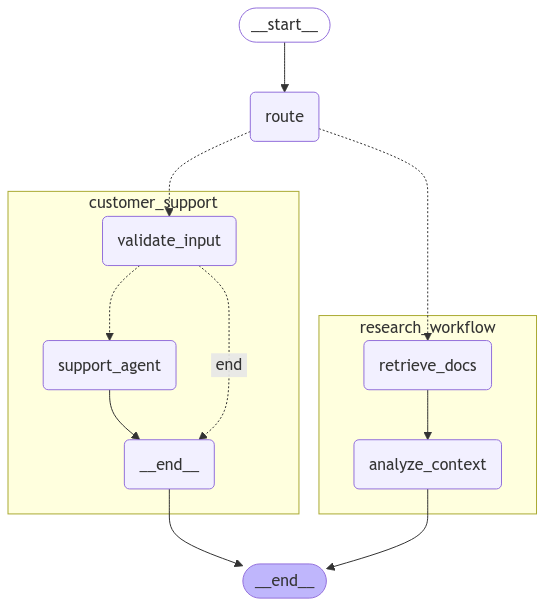

Invoking main workflow with scenario: {'query': "I want to return the laptop I purchased last week. It's not working properly. Please issue refund", 'customer_id': 'CUST001', 'order_id': 'ORD001'}
Routing query to appropriate workflow...
Routing to customer support workflow...
Validating input data...


> Entering new AgentExecutor chain...

Invoking: `sql_db_list_tables` with `{}`


customers, order_items, orders, products, returns
Invoking: `sql_db_query` with `{'query': "SELECT * FROM customers WHERE customer_id = 'CUST001';"}`


[('CUST001', 'John Doe', 'john.doe@example.com', '555-1234')]
Invoking: `sql_db_query` with `{'query': "SELECT * FROM orders WHERE order_id = 'ORD001';"}`


[('ORD001', 'CUST001', '2024-01-15', 1599.98, 'COMPLETED')]
Invoking: `sql_db_query` with `{'query': "SELECT * FROM order_items WHERE order_id = 'ORD001';"}`


[('ORD001', 'PROD001', 1, 999.99), ('ORD001', 'PROD002', 1, 599.99)]
Invoking: `sql_db_query` with `{'query': "SELECT * FROM products WHERE prod

In [12]:
def main():
    print("Starting main workflow...")

    customer_support_subgraph = create_customer_support_subgraph()
    research_assistant_subgraph = create_research_assistant_subgraph(vector_store)

    main_workflow = create_main_workflow(
        customer_support_subgraph,
        research_assistant_subgraph
    )
    print(main_workflow)

    from IPython.display import Image, display

    # Setting xray to 1 will show the internal structure of the nested graph
    display(Image(main_workflow.get_graph(xray=1).draw_mermaid_png()))

    scenarios = [
        {
            "query": "I want to return the laptop I purchased last week. It's not working properly. Please issue refund",
            "customer_id": "CUST001",
            "order_id": "ORD001"
        }
        #  {
        #      "query": "Tell me about return policy"
        #  }
        # {
        #     "query_text": "Can you check the status of my recent smartphone order?",
        #     "customer_id": "CUST002",
        #     "order_id": "ORD002"
        # }
    ]

    # Run through scenarios
    for scenario in scenarios:
            print(f"Invoking main workflow with scenario: {scenario}")
            initial_state = MainWorkflowState(**scenario)
            result = main_workflow.invoke(initial_state)
            print("Workflow Result:", result)

if __name__ == "__main__":
        main()
